# Laboratorio 2
__Integrantes:__ 

- Santiago Martínez Novoa - 202112020 (Estudiante 1)

- María Alejandra Estrada García - 202021060

- Marilyn Stephany Joven Fonseca - 202021346


## Caso de Negocio: Predicción de muertes per capita de cáncer

La Organización Mundial de la Salud está piloteando un nuevo programa de financiamiento que busca intervenir en poblaciones con un alto número de fallecimientos debido al cáncer. El objetivo es permitirle a los gobiernos nacionales y locales invertir en programas de diagnóstico temprano, instalaciones de tratamiento, entrenamiento de personal hospitalario y financiamiento de la investigación en esta enfermedad. Debido a que este programa busca beneficiar al mediano y largo plazo poblaciones vulnerables, se ha determinado la necesidad de crear un modelo predictivo para empezar interviniendo poblaciones que, dadas sus características, tengan un alto número de muertes por cáncer aunque no haya registros completos u oficiales.

Para ello y de la mano del gobierno norteamericano, la OMS ha recopilado datos de Estados Unidos para la creación del modelo a partir de diversas características demográficas y del estado de los servicios de salud de una población para determinar el número de muertes por cáncer por cada 100.000 habitantes. El objetivo, es que este modelo permita tomar decisiones de la asignación de finaciamiento del nuevo programa, además de determinar qué datos son relevantes y cuáles no lo son para la estimación y la recolección de información.

## Instrucciones

La OMS desea que usted los apoye en la construcción del modelo de regresión previamente descrito utilizando algunas de las etapas de la metodología "ASUM-DM":


1. __Entendimiento de los datos:__ 
Describir la característica más relevantes de los datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.


2. __Preparación de datos:__ Solucionar cualquier problema de calidad de datos previamente identificado. Además, debe aplicar cualquier proceso de preprocesamiento de datos necesario para la construcción del modelo de regresión.


3. __Modelado:__ Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.


4. __Evaluación cuantitativa:__ A partir de las métricas seleccionadas para evaluar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo. Contestar a la pregunta: ¿Su equipo recomienda utlizar en producción el modelo de estimación de precios de portátiles o es preferible continuar haciendo estimaciones de forma manual? En caso de no recomendar el uso del modelo, ¿qué recomendaciones haría para continuar iterando con el objetivo de la construcción de un mejor modelo?


5. __Evaluación cualitativa:__ Debe estar compuesta de dos partes:
- Validación de supuestos: Realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.
- Interpretación de los coeficientes: Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y como afectan la variable objetivo.


6. __Visualización de los resultados:__ Integrar el resultado obtenido con el modelo de regresión a un tablero de control para apoyar el objetivo de la empresa.


7. __Exportar el mejor modelo (utilizando pipelines):__ 
Para poder ser usado sobre datos nuevos en el ambiente de producción del cliente.


8. __Predicciones:__
Generar predicciones sobre los datos de prueba que no se encuentran etiquetados utilizando el mejor modelo. Exportar las predicciones en formato CSV utlizando como base el mismo archivo de datos de prueba.

## 0. Preparación inicial

### 0.1. Librerías (Importación)

In [507]:
#Manejo de datos
import pandas as pd
import numpy as np

#Visualización de datos
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Analisis profundo de datos
from ydata_profiling import ProfileReport

#Entrenamiento del modelo
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector

#Persistencia de modelos
from joblib import dump, load

#Librerías extras
import itertools
#Print sklearn version
print(sklearn.__version__)

1.4.1.post1


### 0.2. Carga de datos

In [508]:
#Obtener el dataframe de entrenamiento
train = pd.read_csv('https://raw.githubusercontent.com/SantiagoM99/BI-Esculapio/main/Laboratorio2/Data/202410_Laboratorio%202%20-%20Regresi%C3%B3n_train_data.csv')

#Obtener el dataframe de validación/test
validation = pd.read_csv('https://raw.githubusercontent.com/SantiagoM99/BI-Esculapio/main/Laboratorio2/Data/202410_Laboratorio%202%20-%20Regresi%C3%B3n_val_data.csv')

#Cargar el diccionario
dict_c=pd.read_excel('https://raw.githubusercontent.com/SantiagoM99/BI-Esculapio/main/Laboratorio2/Data/202410_Laboratorio%202%20-%20Regresi%C3%B3n_Diccionario_OMS_Cancer.xlsx')

Se comprueba la carga de los datos de entrenamiento

In [509]:
train.head()

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate
0,37.0,13,521.9,36836,4201,18.3,0.0,"(34218.1, 37413.8]",47.5,44.9,...,30.2,43.2,20.0,88.570752,0.118315,1.135826,0.141978,47.157360,10.704225,169.4
1,107.0,37,412.7,48683,20455,11.7,0.0,"(48021.6, 51046.4]",43.1,42.4,...,44.4,35.7,17.8,97.797657,0.486169,0.116680,0.486169,53.723161,6.550868,131.8
2,22.0,12,472.9,60946,3294,7.4,0.0,"(54545.6, 61494.5]",43.6,43.4,...,48.6,24.5,5.7,95.560385,0.124185,0.000000,2.390562,55.846042,9.935897,209.3
3,20.0,10,527.2,29477,2302,29.5,0.0,"[22640, 34218.1]",49.2,46.8,...,24.7,53.6,27.8,49.613070,49.226139,0.386930,0.000000,38.522167,8.616188,250.0
4,56.0,19,446.4,38478,11310,23.6,0.0,"(37413.8, 40362.7]",37.5,37.4,...,29.8,35.5,20.6,88.516367,0.079197,0.167195,4.593453,52.379740,9.079392,152.5


Se comprueba la carga de los datos de validación

In [510]:
validation.head()

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,250.0,97,461.8,37782,41516,23.2,0.000000,"(37413.8, 40362.7]",42.6,42.2,...,35.0,28.3,46.4,28.7,75.106455,0.616955,0.866157,8.356721,51.013900,4.204317
1,938.0,334,444.5,72973,224469,5.8,280.662363,"(61494.5, 125635]",38.7,37.3,...,71.4,64.9,20.8,9.6,89.673330,3.456320,4.511723,0.631605,63.683814,4.708367
2,29.0,16,372.0,36566,5651,20.9,0.000000,"(34218.1, 37413.8]",42.3,39.8,...,NaN,25.8,41.5,22.3,71.920165,0.481762,0.172058,1.531315,49.431818,4.588745
3,29.0,9,537.2,43523,7121,12.4,0.000000,"(42724.4, 45201]",30.7,29.1,...,43.7,36.6,30.0,21.8,88.979184,1.254634,0.969490,4.348446,49.512411,9.422492
4,499.0,215,457.8,40921,79545,20.2,0.000000,"(40362.7, 42724.4]",43.4,41.4,...,NaN,33.4,39.3,21.8,89.311026,6.803685,0.592285,1.157993,55.248489,5.769696


## 1. Entendimiento de los datos

### 1.1. Exploración de los datos

En primer lugar hay que realizar una exploración y un entendimiento de las columnas que posee el dataset, mediante el diccionario provisto por el negocio.

In [511]:
dict_c

,Atributo,Descripción
0,deathRate,Muertes promedio de cáncer por cada 100.000 ha...
1,avgAnnCount,Número promedio de casos diagnosticados de cán...
2,avgDeathsPerYear,Número promedio de muertes reportadas por cáncer
3,incidenceRate,Número de diagnósticos promedio de cáncer por ...
4,medianIncome,Ingreso mediano por condado
5,poEst2015,Población del condado
6,povertyPercent,Porcentaje de la población en la pobreza
7,studyPerCap,Número de ensayos clínicos relacionados con el...
8,binedInc,Ingreso mediano per capita (clasificado por de...
9,MedianAge,Edad mediana de los residentes del condado


Gracias a la tabla es posible observar que solo existe una columna categórica la cual es Geography, y hay 33 columnas numéricas. A continuación se revisará que el tipo de cada columna corresponda al determinado por el diccionario.

In [512]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              2132 non-null   float64
 1   avgDeathsPerYear         2132 non-null   int64  
 2   incidenceRate            2132 non-null   float64
 3   medIncome                2132 non-null   int64  
 4   popEst2015               2132 non-null   int64  
 5   povertyPercent           2132 non-null   float64
 6   studyPerCap              2132 non-null   float64
 7   binnedInc                2132 non-null   object 
 8   MedianAge                2132 non-null   float64
 9   MedianAgeMale            2132 non-null   float64
 10  MedianAgeFemale          2132 non-null   float64
 11  Geography                2132 non-null   object 
 12  AvgHouseholdSize         2132 non-null   float64
 13  PercentMarried           2132 non-null   float64
 14  PctNoHS18_24            

Se comprueba que no existen inconsistencias frente a los tipos de cada columna en el Dataframe. Como Bined Inc también es un objeto debido a que expresa el ingreso mediano per Capita como un intervalo es necesario transformarlo como si fuera una variable categórica

Posteriormente se revisan las columnas numéricas en búsqueda de datos que sean erróneos o que contradiga la definición dada por el diccionario de las columnas.

In [513]:
train.describe()

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,...,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate
count,2132.000000,2132.000000,2132.000000,2132.000000,2.132000e+03,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,613.385785,183.537992,448.816467,47029.474203,1.025064e+05,16.889681,158.003002,44.298687,39.559475,42.140009,...,41.237899,36.305113,19.282786,83.686321,9.132512,1.260485,1.953356,51.228950,5.643918,179.000047
std,1435.393846,507.649052,53.582307,12107.930677,3.442282e+05,6.415614,533.636824,39.522898,5.208212,5.272267,...,9.326155,7.847326,6.136426,16.588379,14.613785,2.745672,3.484569,6.565620,1.980214,27.416156
min,6.000000,3.000000,201.300000,22640.000000,8.290000e+02,3.200000,0.000000,23.500000,22.800000,22.800000,...,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000,59.700000
25%,77.000000,28.000000,421.600000,38875.750000,1.154725e+04,12.200000,0.000000,37.700000,36.300000,39.000000,...,34.600000,30.975000,14.900000,77.560360,0.614838,0.263542,0.278374,47.749949,4.520411,161.875000
50%,174.500000,62.000000,453.549422,45207.000000,2.693200e+04,15.900000,0.000000,40.900000,39.600000,42.300000,...,41.300000,36.400000,18.900000,90.122747,2.214754,0.538013,0.781727,51.595091,5.383877,178.550000
75%,515.250000,141.000000,481.600000,52376.250000,6.663525e+04,20.300000,79.275307,44.000000,42.600000,45.400000,...,47.600000,41.425000,23.200000,95.600016,10.709158,1.190457,2.171349,55.398869,6.478029,195.300000
max,38150.000000,14010.000000,1014.200000,125635.000000,1.017029e+07,47.400000,9439.200444,619.200000,64.700000,65.700000,...,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,37.859023,78.075397,21.326165,293.900000


Gracias a esta tabla también es posible identificar que no hay valores nulos en nignuna de las columnas, así como tampoco existen valores por fuera de los rangos, lo cual facilita el cumplimiento de las métricas de calidad de los datos.

In [514]:
print(f"El número de atributos es: {train.shape[1]} y el número de instancias es: {train.shape[0]}")

El número de atributos es: 34 y el número de instancias es: 2132


In [515]:
print("Total de registros duplicados iniciales: ",train.duplicated(keep = False).sum())

Total de registros duplicados iniciales:  0


No hay elementos duplicados en todo el registro.

### 1.2. Análisis exploratorio de los datos

#### 1.2.1 Comportamiento variables categóricas 

Luego de haber realizado la exploración de los datos se tomaron las siguientes decisiones. Como el objetivo es encontrar cuales son las condiciones que hacen más propensa a una población de sufrir cancer se comparará esta contra el resto de las variables, como solo hay una sola categórica se va a comprobar su cardinalidad.

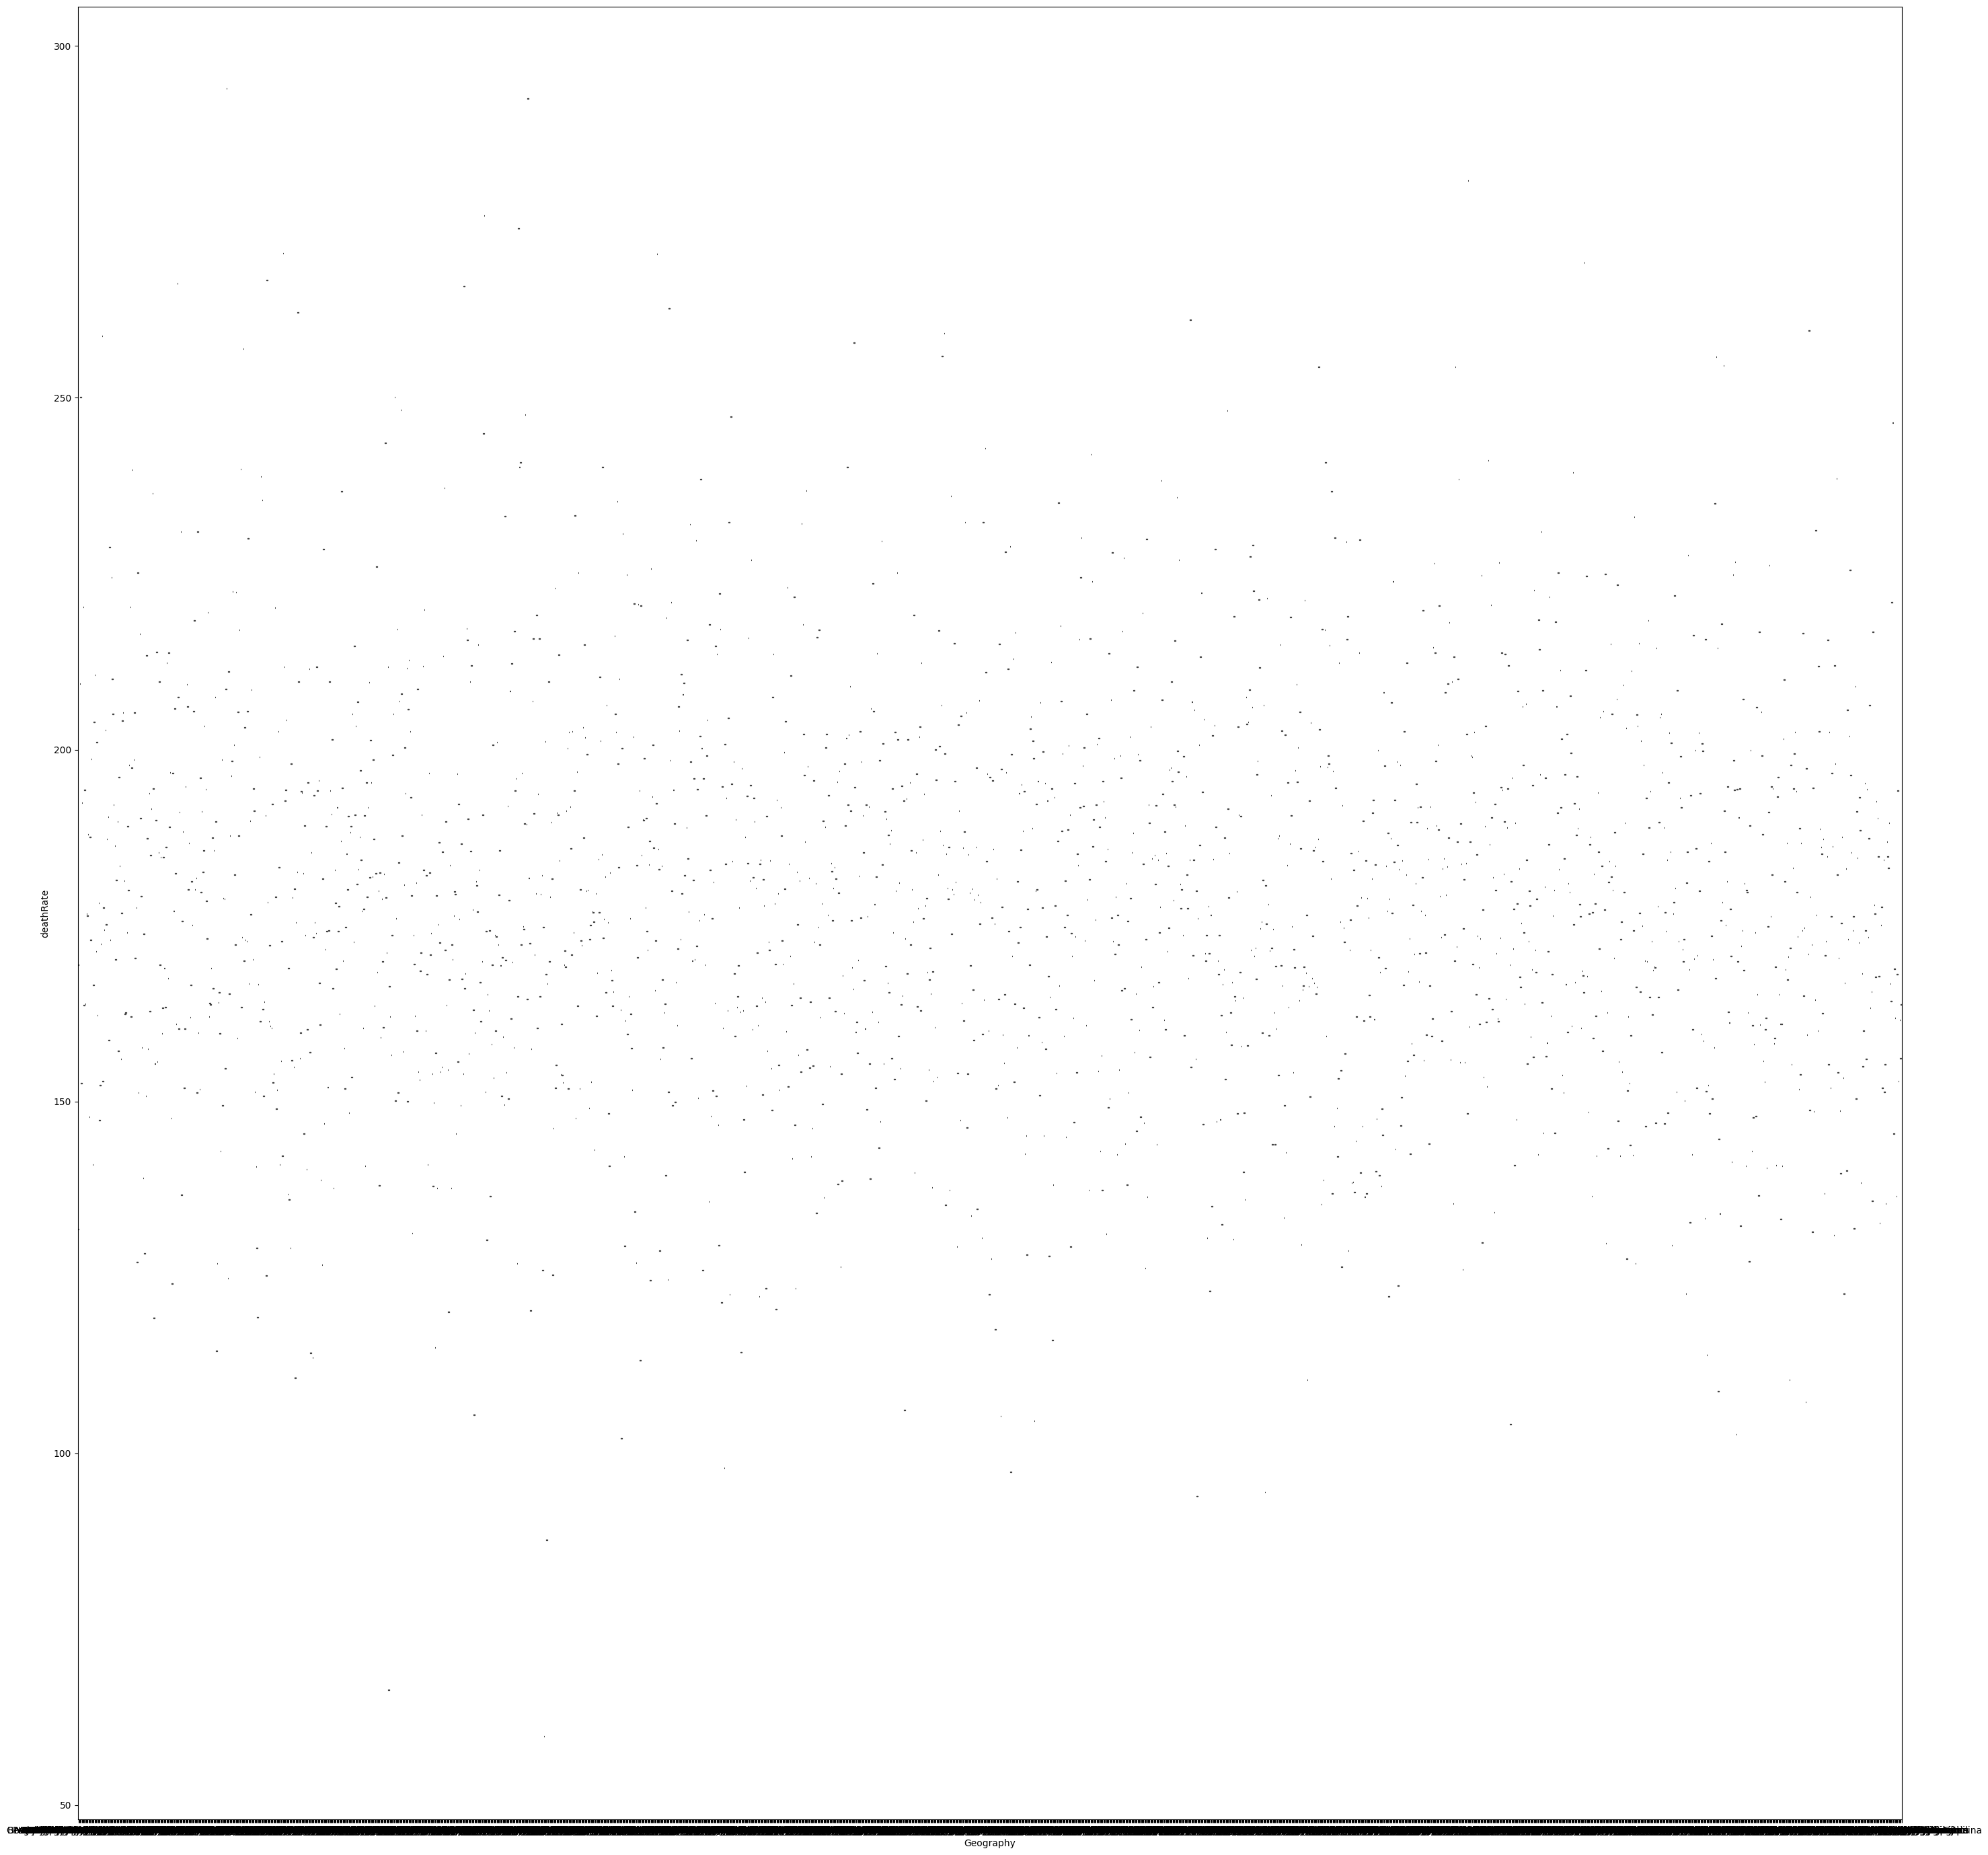

In [516]:
plt.figure(figsize=(35, 35))
sns.boxplot(x='Geography', y='deathRate', data=train)
plt.show()

Como se puede observar la cardinalidad es altísima, lo cual trae problemas curiosos debido a la imposibilidad de utilizar herramientas como OneHotEncoder, no es ideal adicionar una cantidad de columnas tan grande.

In [517]:
num_unique_values = train['Geography'].nunique()
print("Número de valores únicos en la columna 'Geography':", num_unique_values)

Número de valores únicos en la columna 'Geography': 2132


Al revisar la columna se encuentra que la cantidad de valores únicos que hay en el dataset es igual al númeor de registros que se tienen, al inspeccionar un poco más la columna es claro que el problema parece ser es que cada persona fue elegida de un condado distinto. En estados Unidos hay cerca de 3141 condados así que tiene sentido que haya tanta cardinalidad.

Sin embargo, es claro que esta columna tendrá que ser transformada para que aporte algun tipo de valor para elmodelo, lo más certero sería organizarlos por estados, que son solo 50.

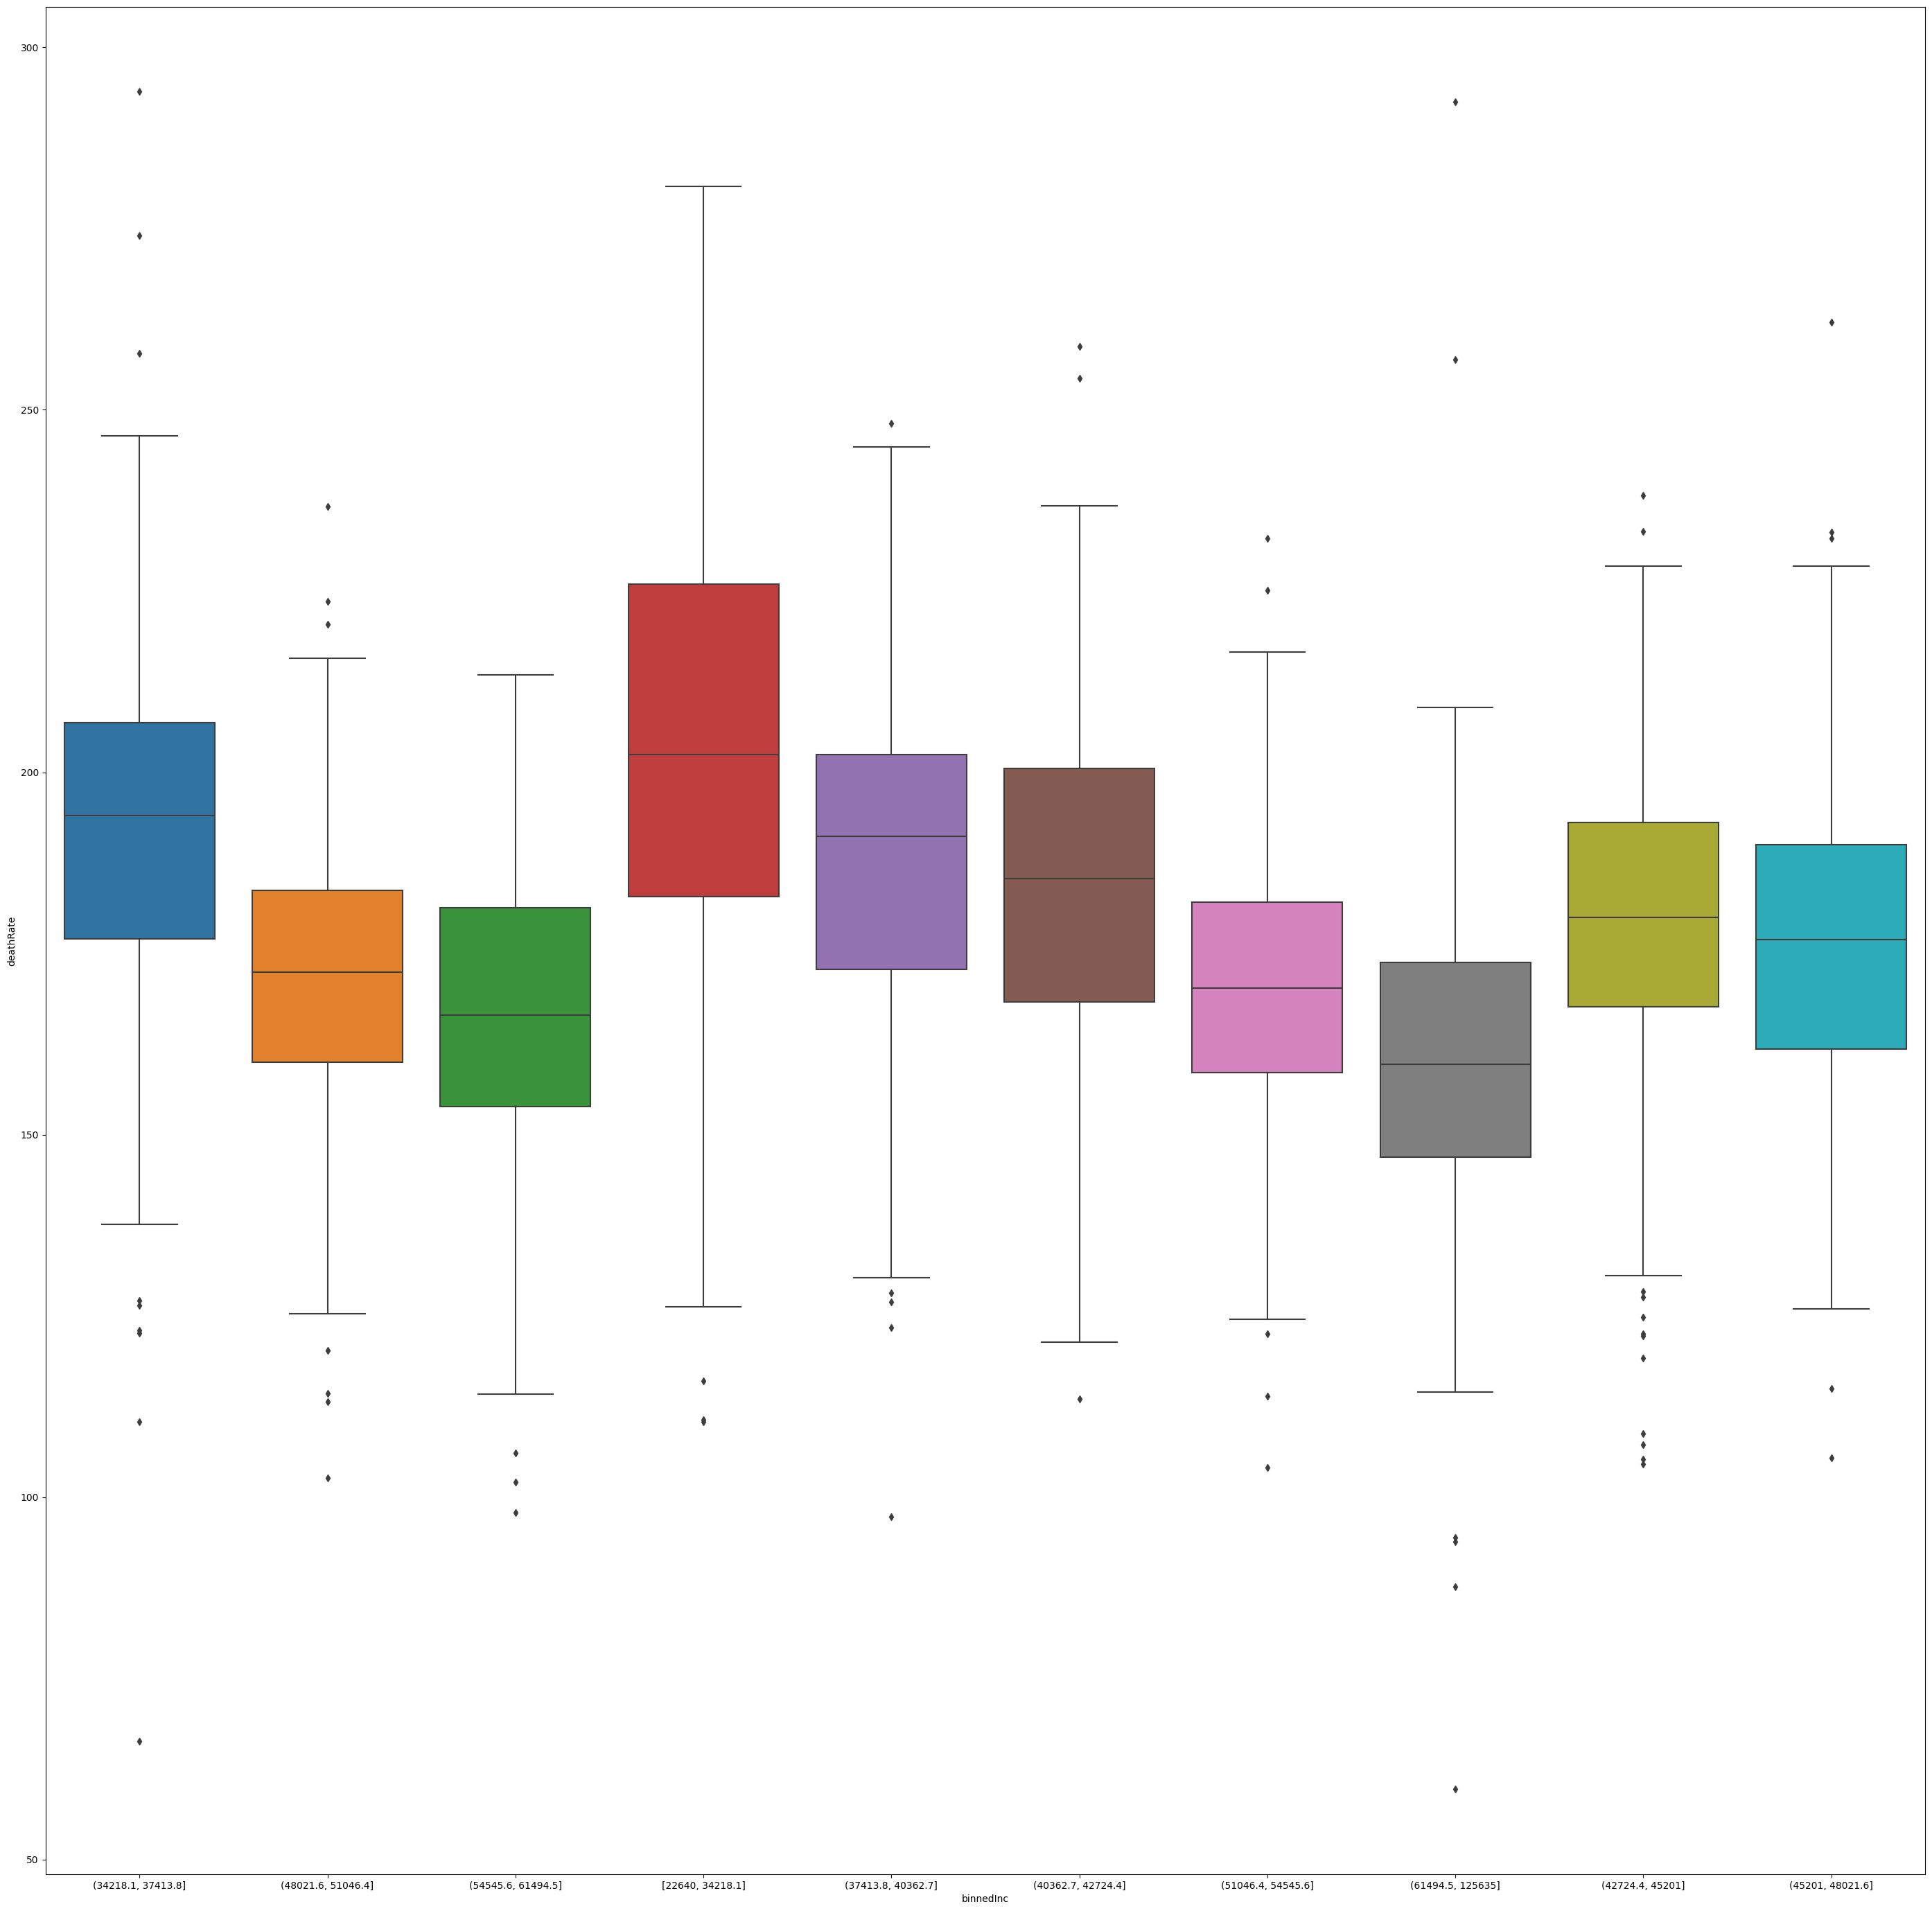

In [518]:
plt.figure(figsize=(35, 35))
sns.boxplot(x='binnedInc', y='deathRate', data=train)
plt.show()

Para la categoría de BinnedInc se puede observar que no hay uina cardinalidad alta, seguramente se le hará un OrdinalEncoder al ser intervvalos que en realidad si tienen un orden entre ellos.

#### 1.3.2. Comportamiento variables numéricas

Ahora se procederá a revisar la correlación de los datos, pues de encontrarse columnas cuya correlación es bastante alta tal vez sea necesario eliminar una de ellas.

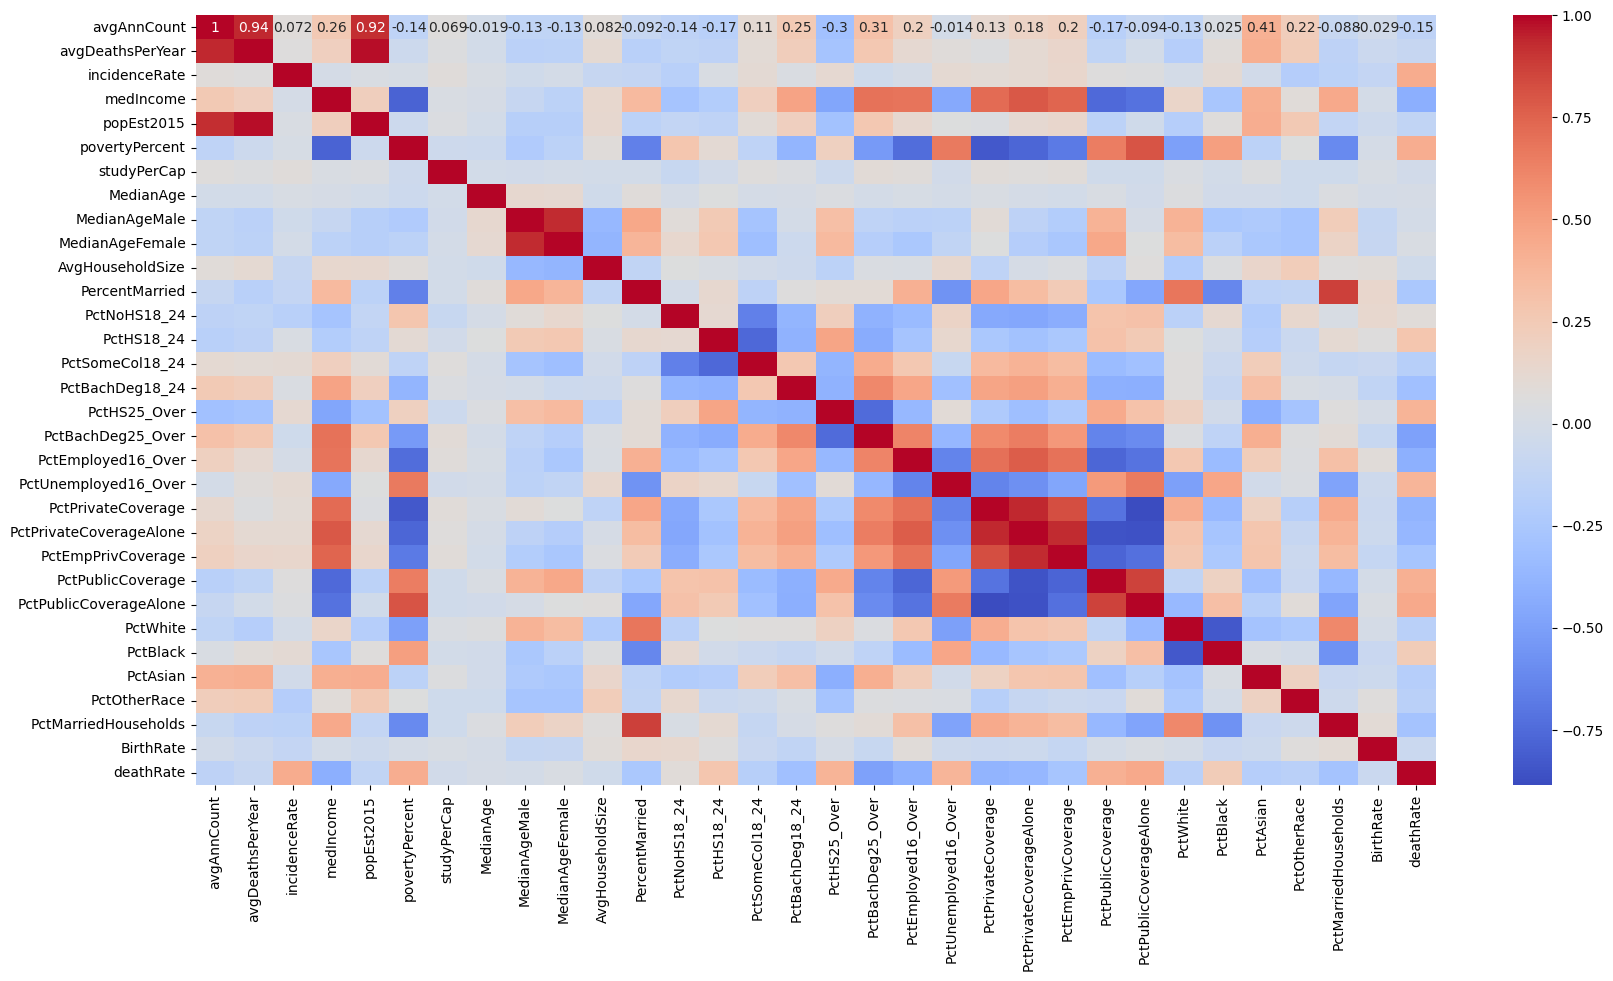

In [519]:
# Filtrar las columnas que son de tipo int o float para quitar las columnas categóricas
numeric_cols = train.select_dtypes(include=['int', 'float'])

# Calcular la matriz de correlación solo para esas columnas
correlation_matrix = numeric_cols.corr()

# Crear el heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


Como se puede ver, existen columnas que poseen alta correlación entre ellas. Será necesario retirar algunas de las columnas relacionadas

La decisión de conservar únicamente una de las características entre las que están correlacionadas se fundamenta en varios atributos de calidad de los datos. En primer lugar, desde la perspectiva de la precisión, mantener ambas características puede redundar en información similar y aumentar la complejidad del conjunto de datos sin mejorar la precisión de los análisis. Además, en términos de coherencia, conservar solo una de las características garantiza una representación de muchos elementos en el conjunto de datos, evitando posibles discrepancias en la interpretación. 

Esta acción también promueve la eficiencia computacional al reducir la dimensionalidad del conjunto de datos, lo que resulta en un procesamiento más rápido y una utilización más eficiente de los recursos. Como son tantas variables se realizará una búsqueda en la que se encuentren las correlaciones con más de 0.8, que es un valor escogido para empezar a realizar la evaluación entre las demás columnas. 

In [520]:
high_correlation_indices = np.where(np.abs(correlation_matrix) > 0.8)

# Filtrar las correlaciones para evitar duplicados y la diagonal principal
correlations = [(numeric_cols.columns[i], numeric_cols.columns[j], correlation_matrix.iloc[i, j])
                for i, j in zip(*high_correlation_indices) if i != j]
printed = []
# Mostrar las correlaciones mayores a 0.8
for col1, col2, corr in correlations:
    if (col1,col2) not in printed and (col1,col2) not in printed:
        print(f"Correlación entre {col1} y {col2}: {corr}")
        printed.append((col1,col2))
        printed.append((col2,col1))

Correlación entre avgAnnCount y avgDeathsPerYear: 0.9358070351605763
Correlación entre avgAnnCount y popEst2015: 0.9239801604159191
Correlación entre avgDeathsPerYear y popEst2015: 0.9798208784089449
Correlación entre povertyPercent y PctPrivateCoverage: -0.8279390173079699
Correlación entre povertyPercent y PctPublicCoverageAlone: 0.8024101448489753
Correlación entre MedianAgeMale y MedianAgeFemale: 0.930866647239451
Correlación entre PercentMarried y PctMarriedHouseholds: 0.870229049879577
Correlación entre PctPrivateCoverage y PctPrivateCoverageAlone: 0.933896313985271
Correlación entre PctPrivateCoverage y PctEmpPrivCoverage: 0.8268921769910806
Correlación entre PctPrivateCoverage y PctPublicCoverageAlone: -0.8857320035675356
Correlación entre PctPrivateCoverageAlone y PctEmpPrivCoverage: 0.926400819861831
Correlación entre PctPrivateCoverageAlone y PctPublicCoverage: -0.8559489070478491
Correlación entre PctPrivateCoverageAlone y PctPublicCoverageAlone: -0.8580025838911827
Correla

De acuerdo con los valores encontrados se concentrará el análisis en las siguierntes cuatro correlaciones:

__avgAnnCount - avgDeathsPerYear:__ Estas dos variables están altamente correlacionadas entre sí (de 0.9358), lo que sugiere una fuerte relación entre el número promedio de casos diagnosticados de cáncer reportados anualmente y el número promedio de muertes reportadas por cáncer. Para evitar repetición de la información se considerará solo mantener el promedio de muertes por año, que es más relacionada con el objetivo del análisis.

__popEst2015 - avgDeathsPerYear:__ También hay una correlación muy alta (0.9798) entre la población estimada en 2015 y el número promedio de muertes reportadas por cáncer. Esto tiene sentido pues a mayor población, mayor cantidad de muertes, sin embargo nuevamente por los objetivos de este análisis solo se mandtendrá el promedio de muertes reportadas.

__PctPrivateCoverage - PctPrivateCoverageAlone:__ Estas dos variables tienen una correlación muy alta (0.9339).

__PctPublicCoverage - PctPublicCoverageAlone:__ Similar al caso anterior, estas dos variables también tienen una correlación alta (0.8646).

Para estas dos variables se determina que lo mejor quedarse con el porcentaje general de ambas,todo con el objetivo de evitar redundancia en la información.

__PctMarriedHouseholds - PercentMarried:__ La correlación entre estas dos columnas es bastante alta (0.8702) por lo que solo se conservará una de ellas,  en este caso no parece haber una mas importante que la otra asi que se conservará PctMarriedHouseholds.

### 1.3. Perfilamiento de los datos

Se realiza el perfilamiento de los datos con la ayuda de pandas-profiling para encontrar otras características que hayan escapado al análisis inicial. Se intentó renderizar en el mismo cuaderno pero presenta severos problemas a la hora de mostrar los resultados.

Se realizó el perfilamiento de los datos sin embargo no se pondrá el resultado aquí sino en un archivo llamado report.html debido a que presenta problemas incluso cuando no se intenta renderizar dentro del notebook. (De todas maneras por el tamaño y el peso del archivo no se recomienda abrirlo)

Lo que se pudo observar fue valores nulos en tres columnas.

In [521]:
round(100*(train.isnull().sum()/len(train)), 2).sort_values(ascending=False)

PctSomeCol18_24            75.23
PctPrivateCoverageAlone    20.08
PctEmployed16_Over          5.39
PctPublicCoverage           0.00
PctBachDeg25_Over           0.00
PctUnemployed16_Over        0.00
PctPrivateCoverage          0.00
PctEmpPrivCoverage          0.00
avgAnnCount                 0.00
PctHS25_Over                0.00
PctWhite                    0.00
PctBlack                    0.00
PctAsian                    0.00
PctOtherRace                0.00
PctMarriedHouseholds        0.00
BirthRate                   0.00
PctPublicCoverageAlone      0.00
PctBachDeg18_24             0.00
avgDeathsPerYear            0.00
PctHS18_24                  0.00
PctNoHS18_24                0.00
PercentMarried              0.00
AvgHouseholdSize            0.00
Geography                   0.00
MedianAgeFemale             0.00
MedianAgeMale               0.00
MedianAge                   0.00
binnedInc                   0.00
studyPerCap                 0.00
povertyPercent              0.00
popEst2015

En primer lugar, `PctSomeCol18_24` debe ser retirada debido a la cantidad elevada de valores nulos que hay, no sirve de nada intentar utilizar la algun método de imputación porque simplemente son demasiados valores nulos. Será necesario eliminarlos.

En segundo lugar, si bien a `PctPrivateCoverageAlone` podría usarse una imputación de datos no será necesario debido a que se determinó que será eliminada para evitar la multicolinealidad.

Finalmente, para `PctEmployed16_Over` si se realizará imputación de los valores nulos porque si se utilizará la columna y porque la cantidad de datos faltantes no son demasiados. Se decide no eliminarlos debido al tamaño de la muestra pues significaría perder información valiosa.

### 1.4. Decisiones de transformación de los datos

Las decisiones se tomarán de acuerdo a los siguientes 4 dimensiones de calidad

#### Consistencia
**Decisión 1:** Eliminar columnas que tienen alta correlación con otras para para evitar la multicolinealidad y asegurar que el modelo sea más estable y fácil de interpretar.

**Decisión 2:** Convertir las columnas categóricas `Geography` y `binnedInc` en variables categóricas utilizando OrdinalEncoder

#### Validez
**Decisión 3:** Transformar los datos de la columna `Geography` para que pueda ser agrupada por estados. Reduciendo la cardinalidad.
#### Unicidad
Los valores ya cumplen con esta dimensión pues no existen registros duplicados en el dataset
#### Completitud
**Decisión 4:** Eliminar la columna `PctSomeCol18_24` debido a su alto porcentaje de valores faltantes.

**Decisión 5:** Imputar valores faltantes a la columna `PctEmployed16_Over` para asegurar que no haya ningún valor nulo en todo el dataset.


## 2. Preparación de los datos

### 2.0. Separación de dataset de validación

Para poder asegurar que el modelo no esté sobreajustado al final del entrenamiento se decidió utilizar cross validation con el método K-folds.

La validación cruzada(cross validation) es un método que ayuda a asegurar la exactitud de las predicciones del modelo del aprendizaje automático que se está utilizando. Este método, implementado con K-Folds, es considerado un procedimiento de “re-sampling” que permite evaluar un modelo incluso con datos limitados, pues divide el conjunto de los datos en k subconjuntos contra los cuales se evalúa el modelo entrenado. Se escogió esta estrategia debido a que, en caso de datos de entrada limitados y de tamaño pequeño, resulta uno de los mejores enfoques. [1]

Por otro lado, para este análisis existe una variable independiente `deathRate` y el resto variables dependientes, de manera que es necesario realizar esta separación:

In [522]:
new_train = train.copy()
X_train, Y_train = new_train.drop(['deathRate'], axis=1), new_train['deathRate']
display(X_train)
Y_train

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,37.0,13,521.9,36836,4201,18.3,0.000000,"(34218.1, 37413.8]",47.5,44.9,...,45.5,30.2,43.2,20.0,88.570752,0.118315,1.135826,0.141978,47.157360,10.704225
1,107.0,37,412.7,48683,20455,11.7,0.000000,"(48021.6, 51046.4]",43.1,42.4,...,52.8,44.4,35.7,17.8,97.797657,0.486169,0.116680,0.486169,53.723161,6.550868
2,22.0,12,472.9,60946,3294,7.4,0.000000,"(54545.6, 61494.5]",43.6,43.4,...,65.0,48.6,24.5,5.7,95.560385,0.124185,0.000000,2.390562,55.846042,9.935897
3,20.0,10,527.2,29477,2302,29.5,0.000000,"[22640, 34218.1]",49.2,46.8,...,26.7,24.7,53.6,27.8,49.613070,49.226139,0.386930,0.000000,38.522167,8.616188
4,56.0,19,446.4,38478,11310,23.6,0.000000,"(37413.8, 40362.7]",37.5,37.4,...,36.5,29.8,35.5,20.6,88.516367,0.079197,0.167195,4.593453,52.379740,9.079392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,506.0,215,461.3,31382,89208,30.8,44.839028,"[22640, 34218.1]",38.7,36.5,...,NaN,30.6,43.0,26.0,34.319625,61.893458,1.024565,0.939553,38.665070,6.172502
2128,176.0,74,368.3,62752,47520,11.0,0.000000,"(61494.5, 125635]",40.4,39.3,...,55.3,47.0,27.0,12.0,93.363950,1.612868,0.263684,1.900723,61.433094,5.291214
2129,4431.0,1477,507.1,70074,776043,10.7,73.449538,"(61494.5, 125635]",40.6,38.9,...,57.0,52.0,37.2,21.4,79.796923,3.912684,3.454740,10.182117,48.513782,4.825363
2130,378.0,157,400.2,55798,78593,11.7,0.000000,"(54545.6, 61494.5]",41.5,40.6,...,58.7,50.2,27.2,13.0,94.254676,1.824259,0.723790,1.400013,58.197468,4.834403


0       169.4
1       131.8
2       209.3
3       250.0
4       152.5
        ...  
2127    194.1
2128    152.8
2129    161.5
2130    156.1
2131    163.7
Name: deathRate, Length: 2132, dtype: float64

### 2.1. Construcción del pipeline 
Como ya se definieron las transformaciones necesarias para la transformación de los datos se va a construir el pipeline para ahorrar tiempo después cuando se quiera repetir el proceso durante la búsqueda de hiperparámetros.

En primer lugar se realizará la eliminación de las columnas de acuerdo con lo establecido en la __Decisión 1__ y en la __Decisión 4__. Luego de eso se imputarán los valores para la columna tal y como se planteó en la __Decisión 5__.

In [523]:
#Definimos columnas a eliminar por correlación
drop_columns_corr = ['avgAnnCount', 'popEst2015', 'PctPrivateCoverageAlone', 'PctPublicCoverageAlone', 'PercentMarried']

#Definimos columnas a eliminar por nulos
drop_columns_null = ['PctSomeCol18_24']

# Define lambda functions at the top level
def delete_corr(data):
    return data.drop(drop_columns_corr, axis=1)

def delete_null(data):
    return data.drop(drop_columns_null, axis=1)

# Construct the pipeline with lambda functions
num_transformer = Pipeline(
    steps=[
        ('delete_corr', FunctionTransformer(delete_corr, validate=False)),
        ('delete_null', FunctionTransformer(delete_null, validate=False)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]
)

Ahora se debe construir un segundo Pipeline, esta vez para la transformación de las columnas categóricas como se especificó en la __Decisión 2__. Para esto primero hay que construir una función complementaria para cumplir con los requerimientos en la __Decisión 3__.

In [524]:
def fix_geography_column(column_value):
    # Split the column value by comma and take the last part
    return column_value.split(",")[-1].strip()

def fix_cat_values(df):
    for column in df.columns:
        if column == 'Geography':
            # Apply the fix_geography_column function to the 'Geography' column
            df[column] = df[column].apply(fix_geography_column)
    return df

#Probar la función
X_train_test = X_train.copy()
X_train_test = fix_cat_values(X_train_test)
print('Estos son los Estados: ',X_train_test['Geography'].unique())
print('Estos son los numeros de estados que hay: ',X_train_test['Geography'].nunique())

Estos son los Estados:  ['South Dakota' 'Wisconsin' 'North Dakota' 'Georgia' 'Idaho' 'Oklahoma'
 'Tennessee' 'Texas' 'New York' 'Kansas' 'Minnesota' 'Mississippi'
 'Kentucky' 'Nebraska' 'Missouri' 'North Carolina' 'Iowa' 'Indiana'
 'Colorado' 'Washington' 'Illinois' 'Pennsylvania' 'Virginia' 'Arkansas'
 'South Carolina' 'Ohio' 'California' 'Alabama' 'Louisiana' 'Michigan'
 'Wyoming' 'New Hampshire' 'Florida' 'Oregon' 'Maine' 'Montana'
 'New Mexico' 'New Jersey' 'West Virginia' 'Alaska' 'Rhode Island'
 'Massachusetts' 'Utah' 'Maryland' 'Nevada' 'Vermont' 'Arizona' 'Hawaii'
 'Delaware' 'Connecticut']
Estos son los numeros de estados que hay:  50


De esta manera se comprueba el buen comportamiento de la función.

A continuación, como ya se ha construido la función complementaria es hora de construir el segundo Pipeline de transformación de las variables categóricas.

Para la variable `binnedInc`, que representa intervalos de ingresos, tiene sentido utilizar un OrdinalEncoder porque estos intervalos pueden ordenarse de manera lógica, es decir, existe un orden inherente entre ellos. Al codificar los intervalos como valores enteros, podemos preservar este orden en la representación numérica de los datos, lo cual es beneficioso.[2]

Por otro lado, la variable Geography, que representa los estados, no tiene un orden intrínseco entre sus valores. Por lo tanto, utilizar un OneHotEncoder para esta variable es más apropiado. Esta codificación es adecuada para representar variables categóricas nominales sin imponer un orden artificial entre las categorías, lo que podría distorsionar la interpretación de los datos.[2] Por el momento se trabajará de esta manera porque se cree que 50 columnas no son demasiadas para que el modelo las maneje.

In [525]:
cat_transformer = Pipeline(
    steps=[
        ('fix_values', FunctionTransformer(fix_cat_values, validate=False)),
        ('ordinal_or_one_hot', ColumnTransformer(
            transformers=[
                ('ordinal_binned', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['binnedInc']),
                ('geo', OneHotEncoder(handle_unknown='ignore'), ['Geography'])
            ],
            remainder='passthrough'
        ))
    ]
)

## 3. Modelamiento

Para este análisis se utilizará un modelo de regresión lineal, para el cual se utilizará un GridSearch para determinar cual es el mejor modelo al realizarle a los datos estandarización, normalización o dejarlos así. Si bien en teoría debería utilizarse StandardScaler, pues al utilizar modelos basados en coeficientes, como la regresión lineal, StandardScaler ofrece una interpretación más directa de los coeficientes [3], se correrán todos los casos y se escojerá el mejor modelo basándose en el RMSE. Adicionalmente Se va a utilizar el método de Regularización de Lasso para identificar los coeficientes mas importantes y poder mejorar la selección de columnas.

### 3.1. Regresión Lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, como en este caso que no se utilizan PolynomialFeatures(), lo que hace el algoritmo es “dibujar una recta” que indicará la tendencia de un conjunto de datos continuos. [4]

Su ecuación es definida como:

Y = β₀ + β₁X₁ + β₂X₂ + ... + βₙXₙ + ε

- Y es la variable dependiente que estamos tratando de predecir.
- β₀ es el intercepto.
- β₁, β₂, ..., βₙ son los coeficientes de regresión que representan la relación entre cada variable independiente (X₁, X₂, ..., Xₙ) y la variable dependiente.
- X₁, X₂, ..., Xₙ son las variables independientes.
- ε es el término de error, que representa la diferencia entre el valor observado y el valor predicho por el modelo.

### 3.2. Búsqueda de hiperparámetros

Como se dijo anteriormente, se va a encontrar el mejor modelo utilizando la métrica RMSE. Pero primero es necesario construir el Pipeline final para poder utilizarlo en el GridSearch.

También hay que encontrar el mejor alpha para la regularización por lo cual hay que definirlo

In [526]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_include=object))   # Lista de columnas categóricas
    ]
)

process = [
        ('transform', preprocessor),
        ('regression', Lasso())  # Regularización Lasso
    ]
pipeline = Pipeline(process)

parameters = {
    'regression__alpha': [0.001, 0.01, 0.1, 1, 2, 3],
    'transform__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'transform__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
}

grid_search = GridSearchCV(pipeline, parameters, verbose=2, scoring='neg_mean_squared_error', cv=5,error_score='raise')


In [527]:
%%time
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s


[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=MinMaxScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=MinMaxScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=MinMaxScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=MinMaxScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=MinMaxScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=passthrough; total time=   0.0s


c:\Users\user\BI-Sabroson\BI-Esculapio\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e+02, tolerance: 1.260e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=mean, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=m

c:\Users\user\BI-Sabroson\BI-Esculapio\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e+02, tolerance: 1.260e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=median, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=most_frequent, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=most_frequent, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__

c:\Users\user\BI-Sabroson\BI-Esculapio\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e+02, tolerance: 1.260e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END regression__alpha=0.001, transform__num__imputer__strategy=most_frequent, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=most_frequent, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=most_frequent, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.001, transform__num__imputer__strategy=most_frequent, transform__num__scaler=passthrough; total time=   0.0s
[CV] END regression__alpha=0.01, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.01, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.01, transform__num__imputer__strategy=mean, transform__num__scaler=StandardScaler(); total time=   0.0s
[CV] END regression__alpha=0.01, transform__num__

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('delete_corr',
                                                                                          FunctionTransformer(func=<function delete_corr at 0x000002D82126C9A0>)),
                                                                                         ('delete_null',
                                                                                          FunctionTransformer(func=<function delete_null at 0x000002D82126C040>)),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002D8236762D0>)])),
                                       ('regression', Lasso())]),
             param_grid={'regression__alpha': [0.001, 0.01, 0.1, 1, 2, 3],
                         'transform__num__imputer__strategy': ['mean', 'median',
                                                               'most_frequent'],
                         'transform__num__scaler': [StandardScaler(),
                                                    MinMaxScaler(),
                                                    'passthrough']},
             scoring='neg_mean_squared_error', verbose=2)

Ahora podemos observar cuales son los mejores parámetros:

In [528]:
best_model = grid_search.best_estimator_

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression__alpha,param_transform__num__imputer__strategy,param_transform__num__scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032481,3.642551e-03,0.006323,0.001211,0.001,mean,StandardScaler(),"{'regression__alpha': 0.001, 'transform__num__...",-402.775313,-363.881759,-301.829829,-339.277034,-331.025744,-347.757936,33.906260,14
1,0.041382,1.532473e-02,0.006135,0.000699,0.001,mean,MinMaxScaler(),"{'regression__alpha': 0.001, 'transform__num__...",-402.319911,-363.590404,-301.655147,-338.947803,-330.866292,-347.475912,33.810329,11
2,0.055645,2.685420e-02,0.005531,0.000534,0.001,mean,passthrough,"{'regression__alpha': 0.001, 'transform__num__...",-402.814165,-363.900588,-301.847851,-339.317723,-331.040487,-347.784163,33.912288,16
3,0.034529,3.665323e-03,0.005400,0.000583,0.001,median,StandardScaler(),"{'regression__alpha': 0.001, 'transform__num__...",-402.778629,-363.798024,-301.842238,-339.309502,-331.025551,-347.750789,33.894427,13
4,0.037863,1.322314e-02,0.005105,0.000490,0.001,median,MinMaxScaler(),"{'regression__alpha': 0.001, 'transform__num__...",-402.324070,-363.506566,-301.667326,-338.979915,-330.866290,-347.468833,33.798787,10
5,0.060200,2.508641e-02,0.005910,0.000375,0.001,median,passthrough,"{'regression__alpha': 0.001, 'transform__num__...",-402.817076,-363.816858,-301.860279,-339.350252,-331.040148,-347.776923,33.900338,15
6,0.038944,4.452725e-03,0.005513,0.000320,0.001,most_frequent,StandardScaler(),"{'regression__alpha': 0.001, 'transform__num__...",-402.776599,-364.516084,-301.830916,-338.989316,-331.025746,-347.827732,33.982379,17
7,0.042084,1.361523e-02,0.005320,0.000743,0.001,most_frequent,MinMaxScaler(),"{'regression__alpha': 0.001, 'transform__num__...",-402.321646,-364.224501,-301.656221,-338.665906,-330.866291,-347.546913,33.886529,12
8,0.065603,2.445100e-02,0.005306,0.000400,0.001,most_frequent,passthrough,"{'regression__alpha': 0.001, 'transform__num__...",-402.815320,-364.534851,-301.848937,-339.029141,-331.040385,-347.853727,33.988348,18
9,0.015851,7.675596e-04,0.005215,0.000244,0.01,mean,StandardScaler(),"{'regression__alpha': 0.01, 'transform__num__i...",-403.910925,-363.874346,-300.912099,-335.752035,-328.730178,-346.635916,34.949483,5


In [529]:
grid_search.best_params_

{'regression__alpha': 0.01,
 'transform__num__imputer__strategy': 'median',
 'transform__num__scaler': MinMaxScaler()}

Es sorpresivo que haya escogido MinMaxScaler(), sin embargo es el mejor modelo, de acuerdo con el RMSE.

In [530]:
y_pred_train_lasso = best_model.predict(X_train)
y_pred_train_lasso

array([182.07028463, 172.54142216, 168.46976812, ..., 170.11711279,
       171.12169296, 146.57397547])

In [531]:
n,p = X_train.shape

print('------------ Regresión  Regularizada Lasso con entrenamiento------------')
print("Residual sum of squares (RMSE): %.2f" % np.sqrt(mean_squared_error(Y_train, y_pred_train_lasso)))
print("Mean Absolute Error (MAE): %.2f" % mean_absolute_error(Y_train, y_pred_train_lasso))
print("R2-score: %.5f" % r2_score(Y_train, y_pred_train_lasso) )
print("Adj R2-score: %.5f" % ( 1-(1-r2_score(Y_train, y_pred_train_lasso))*(n-1)/(n-p-1)) )

------------ Regresión  Regularizada Lasso con entrenamiento------------
Residual sum of squares (RMSE): 17.85
Mean Absolute Error (MAE): 13.00
R2-score: 0.57576
Adj R2-score: 0.56909


Los resultados de la __regresión regularizada Lasso__ proporcionan información valiosa sobre la calidad del modelo y su capacidad para predecir los valores objetivo. El residual sum of squares (RMSE) de 17.85 indica que, en promedio, las predicciones del modelo tienen un error de aproximadamente 17.85 unidades en la misma escala que la variable objetivo. Por otro lado, el Mean Absolute Error (MAE) de 13.00 muestra que el valor absoluto del error medio es de 13.00 unidades, lo que sugiere una discrepancia baja entre las predicciones y los valores reales.

El coeficiente de determinación (R2-score) de 0.57576 revela que alrededor del 57.58% de la variabilidad en la variable objetivo puede ser explicada por las características utilizadas en el modelo. Esto indica una capacidad de predicción moderada del modelo. Sin embargo, para tener en cuenta el número de características y evitar el sobreajuste, es útil considerar el R2 ajustado. El valor de 0.56909 para el R2 ajustado muestra que, después de ajustar el modelo para tener en cuenta el número de características, alrededor del 56.91% de la variabilidad en la variable objetivo sigue siendo explicada.

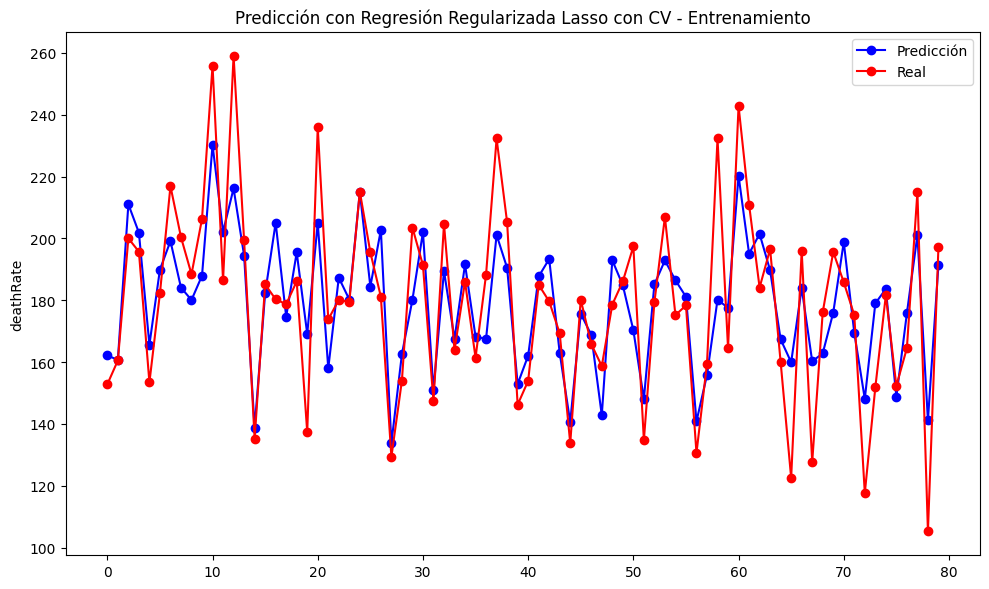

In [532]:
%matplotlib inline

a = 1000
b = 1080
plt.figure(figsize=(10, 6))
xvals = list(range(b-a))
plt.plot(xvals, y_pred_train_lasso[a:b], 'bo-', label='Predicción')
plt.plot(xvals, Y_train[a:b], 'ro-', label='Real')

plt.title('Predicción con Regresión Regularizada Lasso con CV - Entrenamiento')
plt.ylabel(Y_train.name)
plt.legend()

plt.tight_layout()
plt.show()


Ahora se exportará el pipeline del mejor modelo de la búsqueda en grilla.

In [533]:
dump(best_model, 'linearRegression.pkl')

['linearRegression.pkl']

### 3.3 Cálculo de coeficientes

Ahora se van a encontrar las columnas más representativas del modelo para poder realizar una mejor selección de las columnas.

In [534]:
lasso_model = best_model['regression']
print(lasso_model)
trans_df = pd.DataFrame(best_model['transform'].transform(X_train))
cat_transformer.fit(X_train)
one_hot_encoder = cat_transformer.named_steps['ordinal_or_one_hot'].named_transformers_['geo']
ordinal_encoder = cat_transformer.named_steps['ordinal_or_one_hot'].named_transformers_['ordinal_binned']
cat_column_names = list(ordinal_encoder.get_feature_names_out()) + list(one_hot_encoder.get_feature_names_out())

numeric_column_names = [col for col in X_train.columns if col not in cat_column_names and col not in drop_columns_corr and col not in drop_columns_null and not 'Geography' in col]
all_column_names = numeric_column_names + cat_column_names


col_names = all_column_names

print(f'Intercepto: {lasso_model.intercept_}')
coef = list(zip(['Intercepto'] + list(col_names), [lasso_model.intercept_] + list(lasso_model.coef_)))
coef = pd.DataFrame(coef,columns=['Variable','Parámetro'])
coef

Lasso(alpha=0.01)
Intercepto: 155.62142114759138


,Variable,Parámetro
0,Intercepto,155.621421
1,avgDeathsPerYear,-0.000000
2,incidenceRate,141.291650
3,medIncome,0.000000
4,povertyPercent,3.145401
...,...,...
72,Geography_Virginia,10.175548
73,Geography_Washington,-0.681067
74,Geography_West Virginia,5.146982
75,Geography_Wisconsin,0.000000


Para visualizar los datos de una mejor manera se graficarán las 5 variables con el coeficiente más alto.

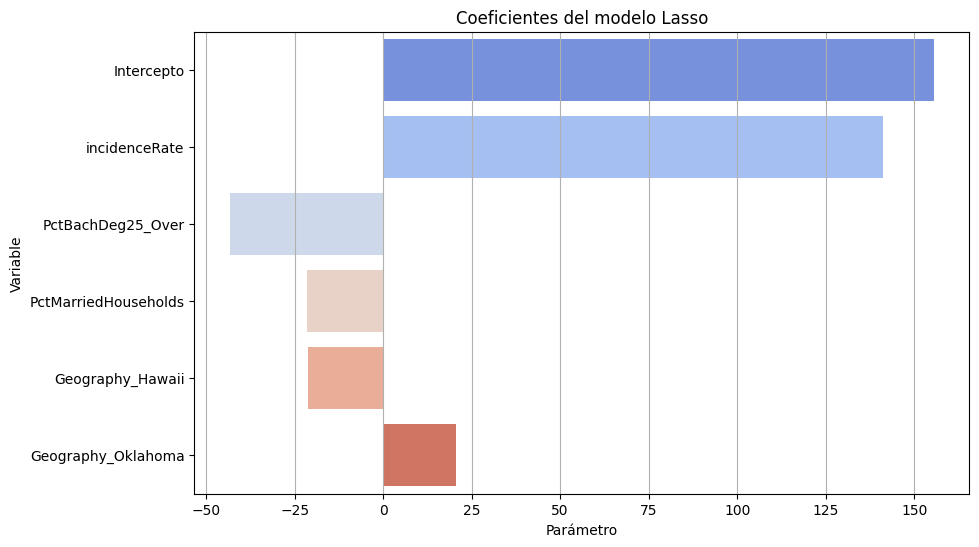

In [535]:
coef_df = coef.copy()
# Filtrar las variables con coeficientes distintos de cero
coef_df = coef_df[coef_df['Parámetro'] != 0]

# Ordenar por valor absoluto de los coeficientes para facilitar la visualización
coef_df['Abs_Parámetro'] = coef_df['Parámetro'].abs()
coef_df = coef_df.sort_values(by='Abs_Parámetro', ascending=False).head(6)

# Graficar los coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x='Parámetro', y='Variable', data=coef_df, palette='coolwarm')
plt.xlabel('Parámetro')
plt.ylabel('Variable')
plt.title('Coeficientes del modelo Lasso')
plt.grid(axis='x')
plt.show()

A continuación se mostrarán por separado las gráficas de ubicación geográfica que de las demás variables

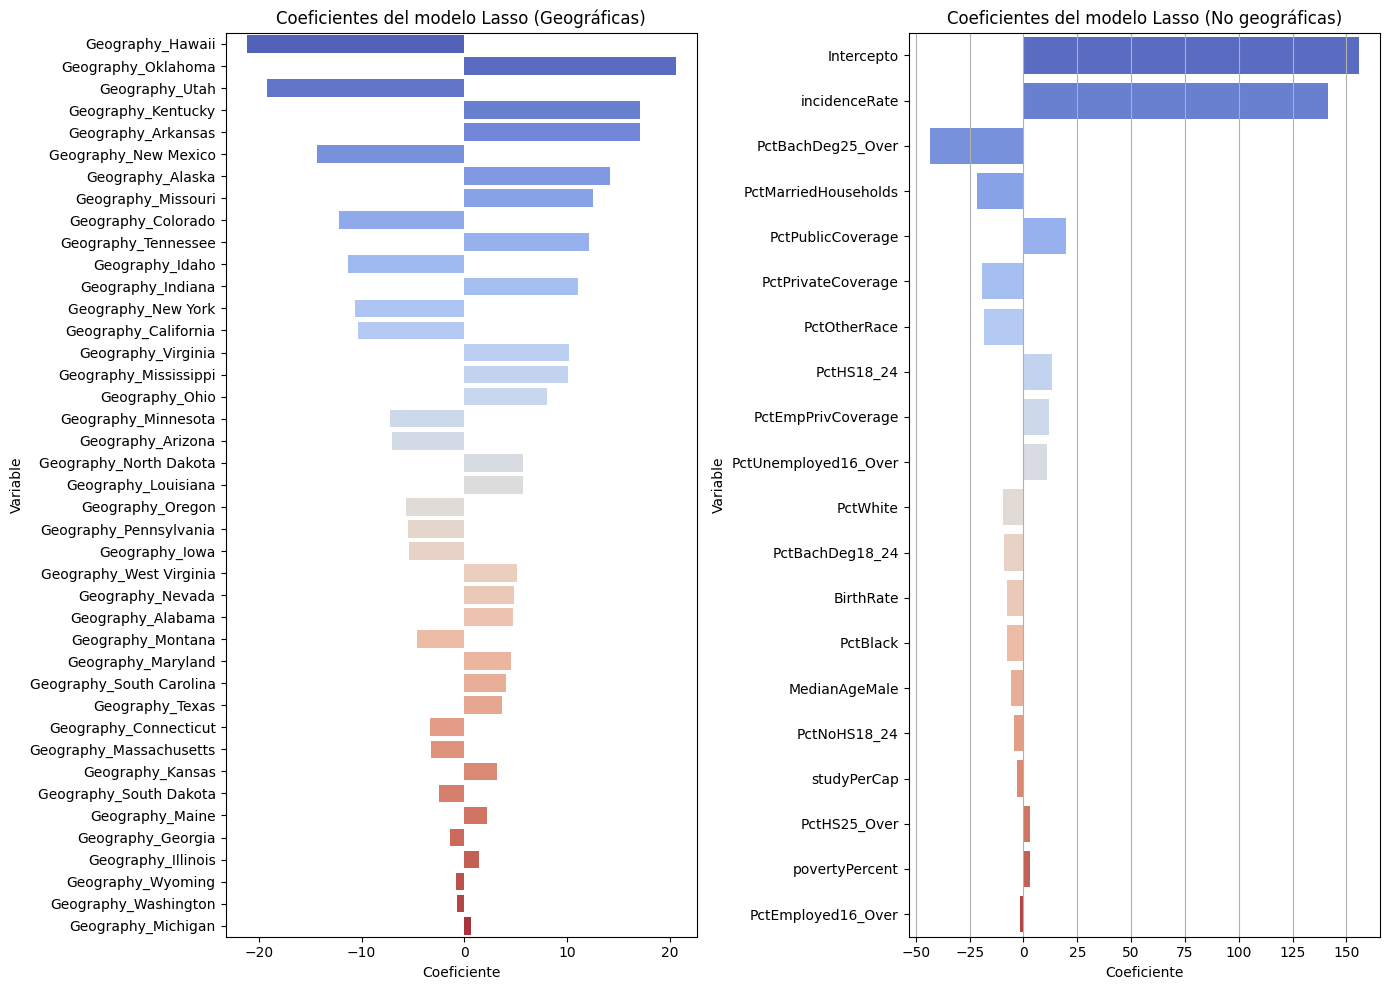

In [536]:
coef_df2 = coef.copy()
coef_df2 = coef_df2[abs(coef_df2['Parámetro']) >= 0.5]
coef_df2['Abs_Parámetro'] = coef_df2['Parámetro'].abs()
coef_df2 = coef_df2.sort_values(by='Abs_Parámetro', ascending=False)
# Crear una figura y un eje
plt.figure(figsize=(14, 10))

# Subgráfico 1: Mostrar las variables más significativas que son de geografía
plt.subplot(1, 2, 1)

# Graficar las variables más significativas que empiezan con Geo
sns.barplot(x='Parámetro', y='Variable', data=coef_df2[coef_df2['Variable'].str.startswith('Geo')], palette='coolwarm')


# Añadir título y etiquetas a los ejes
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.title('Coeficientes del modelo Lasso (Geográficas)')


# Subgráfico 2: Mostrar las demás variables agrupadas por tipo de variable que no son de geografía
plt.subplot(1, 2, 2)

# Filtrar las variables que no son de geografía
sns.barplot(x='Parámetro', y='Variable', data=coef_df2[~coef_df2['Variable'].str.startswith('Geo')], palette='coolwarm')


# Añadir título y etiquetas a los ejes
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.title('Coeficientes del modelo Lasso (No geográficas)')

# Mostrar la cuadrícula en el eje X
plt.grid(axis='x')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Referencias
[1] https://datascientest.com/es/cross-validation-definicion-e-importancia

[2] https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

[3] https://vitalflux.com/minmaxscaler-standardscaler-python-examples/

[4] https://aprendeia.com/algoritmo-regresion-lineal-simple-machine-learning/